<h1><span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Install-Dependence" data-toc-modified-id="Install-Dependence-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Install Dependence</a></span></li><li><span><a href="#Import-Library" data-toc-modified-id="Import-Library-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Library</a></span></li><li><span><a href="#Show-Version" data-toc-modified-id="Show-Version-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Show Version</a></span></li><li><span><a href="#Global-Constants" data-toc-modified-id="Global-Constants-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Global Constants</a></span></li><li><span><a href="#Random-Seed" data-toc-modified-id="Random-Seed-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Random Seed</a></span></li><li><span><a href="#Prepare-Data" data-toc-modified-id="Prepare-Data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Prepare Data</a></span><ul class="toc-item"><li><span><a href="#Train-Data" data-toc-modified-id="Train-Data-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Train Data</a></span></li><li><span><a href="#Valid-Data" data-toc-modified-id="Valid-Data-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Valid Data</a></span></li><li><span><a href="#Test-Data" data-toc-modified-id="Test-Data-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Test Data</a></span></li></ul></li><li><span><a href="#Sample-Data-Exploration" data-toc-modified-id="Sample-Data-Exploration-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Sample Data Exploration</a></span><ul class="toc-item"><li><span><a href="#Data-Distribution" data-toc-modified-id="Data-Distribution-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Data Distribution</a></span></li><li><span><a href="#Define-Display-Image-Method" data-toc-modified-id="Define-Display-Image-Method-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Define Display Image Method</a></span></li><li><span><a href="#Display-Raw-Sample-Images" data-toc-modified-id="Display-Raw-Sample-Images-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Display Raw Sample Images</a></span></li><li><span><a href="#Data-Augment-Transform" data-toc-modified-id="Data-Augment-Transform-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>Data Augment Transform</a></span></li><li><span><a href="#Display-Augment-Images" data-toc-modified-id="Display-Augment-Images-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Display Augment Images</a></span></li></ul></li><li><span><a href="#Build-Network" data-toc-modified-id="Build-Network-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Build Network</a></span><ul class="toc-item"><li><span><a href="#Load-Pretrained-Model" data-toc-modified-id="Load-Pretrained-Model-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Load Pretrained Model</a></span></li><li><span><a href="#Freezing-Layers" data-toc-modified-id="Freezing-Layers-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Freezing Layers</a></span></li><li><span><a href="#Remove-FC-Layer" data-toc-modified-id="Remove-FC-Layer-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Remove FC Layer</a></span></li><li><span><a href="#Model/-Loss/Optimizer" data-toc-modified-id="Model/-Loss/Optimizer-8.4"><span class="toc-item-num">8.4&nbsp;&nbsp;</span>Model/ Loss/Optimizer</a></span></li></ul></li><li><span><a href="#Train" data-toc-modified-id="Train-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#Predict" data-toc-modified-id="Predict-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Predict</a></span></li><li><span><a href="#Plot-Metrics" data-toc-modified-id="Plot-Metrics-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Plot Metrics</a></span></li><li><span><a href="#Submission" data-toc-modified-id="Submission-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Submission</a></span></li></ul></div>

In [1]:
! [ ! -L /kaggle ] && ln -s /data/kaggle /kaggle 

##  Install Dependence

In [2]:
# !pip install pytorch_lightning GPUtil > /dev/null

## Import Library

In [3]:
import os
import zipfile
import GPUtil
import random
import pytorch_lightning as pl
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torch.nn import functional as F
from torch.utils.data import (Dataset, DataLoader)
from torchvision.transforms import (
        Resize,
        Compose,
        ToTensor,
        Normalize,
        RandomOrder,
        ColorJitter,
        RandomRotation,
        RandomGrayscale,
        RandomResizedCrop,
        RandomVerticalFlip,
        RandomHorizontalFlip)

from PIL import Image, ImageDraw, ImageFont
from sklearn.model_selection import train_test_split
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

%matplotlib inline

## Show Version

In [4]:
np.__version__, pd.__version__, sns.__version__

('1.18.5', '1.0.4', '0.10.1')

In [5]:
torch.__version__, torchvision.__version__, pl.__version__

('1.6.0.dev20200609+cu101', '0.7.0.dev20200609+cu101', '0.9.0')

## Global Constants

In [6]:
RNG_SEED = 9527
DATA_ROOT = '/kaggle/input/dogs-vs-cats'
WORK_ROOT = '/kaggle/working'
CKPT_PATH = f'{WORK_ROOT}/checkpoints/best.ckpt'
SUBMITCSV = f'{WORK_ROOT}/submission.csv'
FONT_PATH = '/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.ttf'
LABEL_ID_MAP = {'dog': 0, 'cat': 1}
ID_LABEL_MAP = {0: 'dog', 1: 'cat'}

INPUT_SIZE = 224
BATCH_SIZE = 128
NUM_CLASSES = 2

MAX_EPOCHS = 30

DATASET_MEAN = (0.485, 0.456, 0.406)
DATASET_STD = (0.229, 0.224, 0.225)

TEST_SPLIT = 0.3

In [7]:
!ls $WORK_ROOT

checkpoints  submission.csv  test1  train


## Random Seed

In [8]:
torch.manual_seed(RNG_SEED)
np.random.seed(RNG_SEED)
random.seed(RNG_SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Prepare Data

In [9]:
if not os.path.exists(f'{WORK_ROOT}/train'):
    with zipfile.ZipFile(f'{DATA_ROOT}/train.zip', 'r') as z:
        z.extractall(f'{WORK_ROOT}')
        
if not os.path.exists(f'{WORK_ROOT}/test1'):
    with zipfile.ZipFile(f'{DATA_ROOT}/test1.zip', 'r') as z:
        z.extractall(f'{WORK_ROOT}')

### Train Data

In [10]:
filenames = os.listdir(f'{WORK_ROOT}/train')
label_ids = [LABEL_ID_MAP[str(fname)[:3]] for fname in filenames]
train_df = pd.DataFrame({'filename': filenames, 'label': label_ids})
train_df[10:15]

,filename,label
10,dog.9560.jpg,0
11,dog.11248.jpg,0
12,cat.309.jpg,1
13,cat.7599.jpg,1
14,dog.3439.jpg,0


### Valid Data

In [11]:
train_df, valid_df = train_test_split(train_df, test_size = TEST_SPLIT)
valid_df[10:15]

,filename,label
17039,cat.2178.jpg,1
12605,cat.3442.jpg,1
12511,dog.7645.jpg,0
988,dog.9408.jpg,0
1435,cat.12128.jpg,1


### Test Data

In [12]:
filenames = os.listdir(f'{WORK_ROOT}/test1')
label_ids = [ -1 for x in filenames]
test_df = pd.DataFrame({'filename': filenames, 'label': label_ids})
test_df[10:15]

,filename,label
10,7386.jpg,-1
11,10406.jpg,-1
12,6236.jpg,-1
13,9196.jpg,-1
14,1546.jpg,-1


## Sample Data Exploration

### Data Distribution

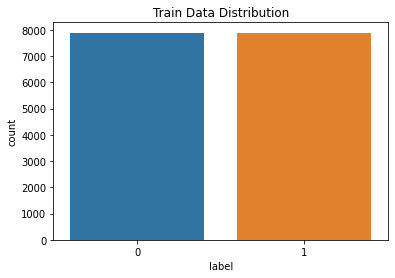

In [13]:
sns.countplot(x='label',data=train_df).set_title("Train Data Distribution");

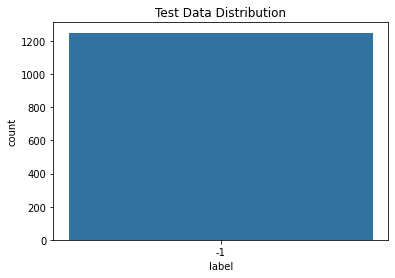

In [14]:
sns.countplot(x='label',data=test_df).set_title("Test Data Distribution");

### Define Display Image Method

In [15]:
def draw_image(filepath, labelname, resize=None, augtrans=None):
    img = Image.open(filepath).convert('RGB')
    if resize is not None:
        img = img.resize((resize, resize))
    if augtrans is not None:
        img = augtrans(img)
        
    font_obj = ImageFont.truetype(FONT_PATH, 48)
    draw_img = ImageDraw.Draw(img)
    font = ImageFont.load_default()
    draw_img.text((0, 0), labelname, font=font_obj, fill=(0, 0, 255))
    return np.array(img)

def grid_image(imgs_list, cols=4):
    images = torch.as_tensor(imgs_list) # [(W, H, C)...] to (B, H, W, C)
    images = images.permute(0, 3, 1, 2) # (B, H, W, C) to (B, C, H, W)
    images = torchvision.utils.make_grid(images, nrow=4) # (C, 2*H, 4*W)
    images = images.permute(1, 2, 0) # (H, W, C)
    return images

### Display Raw Sample Images

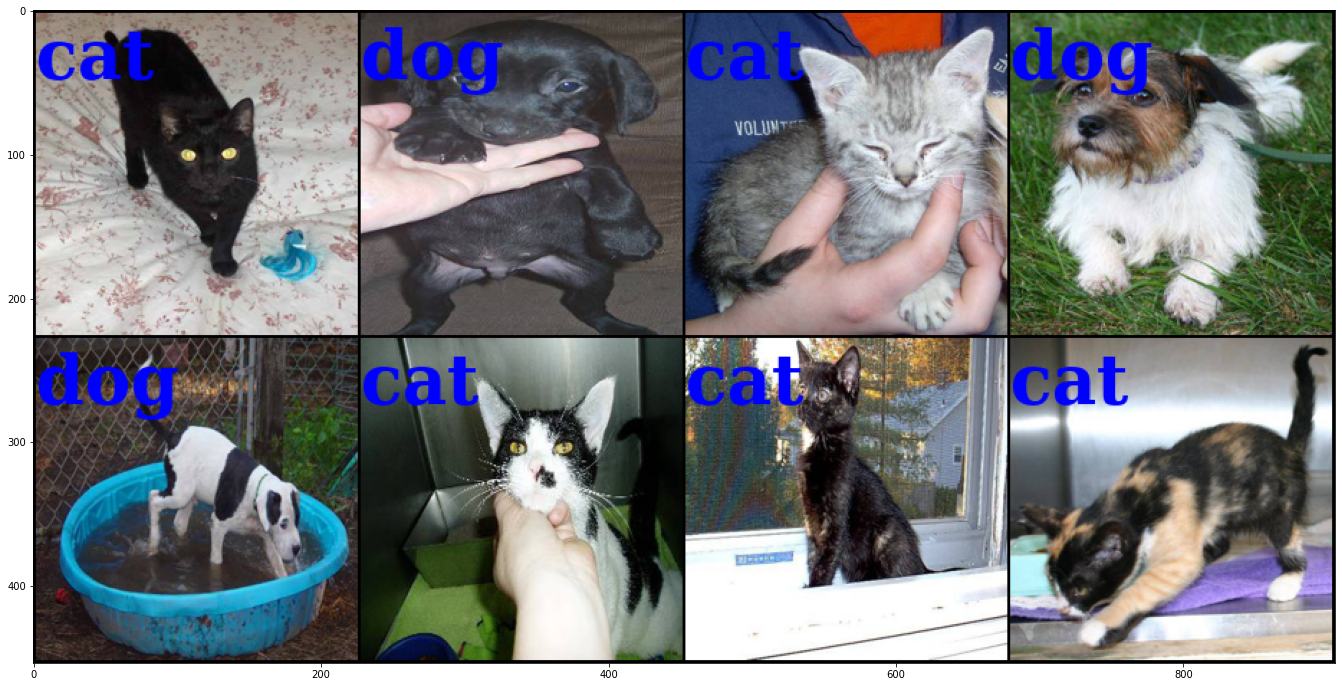

In [16]:
plt.figure(figsize=(24, 12))

images_2x4 = [
    draw_image(
        filepath=f'{WORK_ROOT}/train/{row.filename}',
        labelname=f'{ID_LABEL_MAP[row.label]}',
        resize=INPUT_SIZE
    ) for _, row in train_df[:8].iterrows()
]

plt.imshow(grid_image(images_2x4, cols=4));

### Data Augment Transform

In [17]:
aug_trans = RandomOrder([
    RandomResizedCrop((INPUT_SIZE, INPUT_SIZE)),
    RandomRotation(degrees=10),
    RandomVerticalFlip(p=0.3),
    RandomHorizontalFlip(p=0.3),
    ColorJitter(brightness=0.55, contrast=0.3, saturation=0.25, hue=0),
])

img_trans = Compose([
    Resize((INPUT_SIZE, INPUT_SIZE)),
    ToTensor(),
    Normalize(mean=DATASET_MEAN, std=DATASET_STD),
])

### Display Augment Images

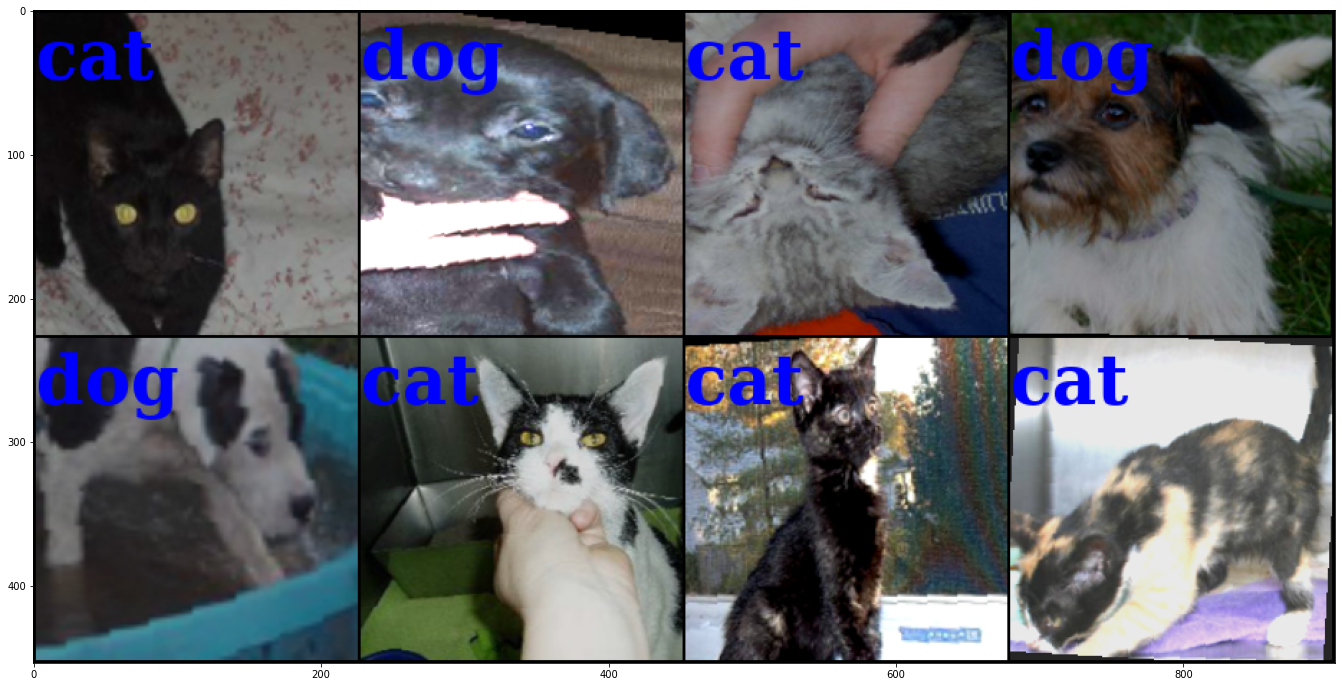

In [18]:
plt.figure(figsize=(24, 12))

trans_images_2x4 = [
    draw_image(
        filepath=f'{WORK_ROOT}/train/{row.filename}',
        labelname=f'{ID_LABEL_MAP[row.label]}',
        resize=INPUT_SIZE,
        augtrans = aug_trans
    ) for _, row in train_df[:8].iterrows()
]

plt.imshow(grid_image(trans_images_2x4, cols=4));

## Build Network

### Load Pretrained Model

In [19]:
backbone = torchvision.models.resnet50(pretrained=True)

### Freezing Layers

In [20]:
for param in backbone.parameters():
    param.requires_grad = False

### Remove FC Layer

In [21]:
extractor = list(backbone.children())[:-2] # avgpool and fc

### Model/ Loss/Optimizer 

In [22]:
METRICS = {
    'epoch':[],
    'train_loss':[],
    'train_acc':[],
    'val_acc':[],
    'val_loss':[],
}

class DCDataset(Dataset):
    def __init__(self, root, df, augtrans=None, imgtrans=ToTensor()):
        super().__init__()
        self.data = [(f'{root}/{row.filename}', row.label) for _, row in df.iterrows()]
        self.augtrans = augtrans
        self.imgtrans = imgtrans
    
    def __getitem__(self, index):
        imgpath, label = self.data[index]
        img = Image.open(imgpath).convert('RGB')
        if self.augtrans:
            img = self.augtrans(img)
        img = self.imgtrans(img)
        return img, label, imgpath
    
    def __len__(self):
        return len(self.data)

class DCNet(pl.LightningModule):
    def __init__(self, extractor, num_classes=NUM_CLASSES):
        super().__init__()
        self.features = nn.Sequential(
            *extractor, # 2048, 7, 7
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=2048, out_channels=1024, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=1),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=256, momentum=0.1),
            nn.MaxPool2d(kernel_size=5, stride=1, padding=2, ceil_mode=False),
            nn.Dropout(inplace=True, p=0.5)
        )
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(in_features=256, out_features=128, bias=True),
            nn.Dropout(inplace=True, p=0.5),
            nn.Linear(in_features=128, out_features=num_classes, bias=True),
        )

  
    def forward(self, x, *args, **kwargs):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x
        
    def setup(self, stage):
        torch.cuda.empty_cache()

    def teardown(self, stage):
        for idx, gpu in enumerate(GPUtil.getGPUs()):
            allocmem = round(torch.cuda.memory_allocated(idx) / 1024**2, 2)
            allocmax = round(torch.cuda.max_memory_allocated(idx) / 1024**2, 2)
            print(f'({stage})\tGPU-{idx} mem allocated: {allocmem} MB\t maxmem allocated: {allocmax} MB')
            
    @property
    def metrics(self):
        return self.metrics
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=0.001,
            weight_decay=0.001
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.1,
            patience=3,
            min_lr=1e-6)
        return [optimizer], [scheduler]
    
    def prepare_data(self):
        self.train_dataset = DCDataset(f'{WORK_ROOT}/train', train_df, aug_trans, img_trans) 
        self.valid_dataset = DCDataset(f'{WORK_ROOT}/train', valid_df, None, img_trans) 
        self.test_dataset = DCDataset(f'{WORK_ROOT}/test1', test_df, None, img_trans) 

    def train_dataloader(self):
        return DataLoader(
                self.train_dataset,
                batch_size=BATCH_SIZE,
                num_workers=4,
                drop_last=True,
                shuffle=True)
    
    def training_step(self, batch, batch_idx):
        x, y_true, path = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y_true, reduction='mean')
        acc = (torch.argmax(y_pred, dim=1) == y_true).float().mean()
        return {'loss': loss, 'acc': acc}

    def training_epoch_end(self, outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean()
        acc = torch.stack([x['acc'] for x in outputs]).mean()
        METRICS['epoch'].append(self.current_epoch)
        METRICS['train_loss'].append(loss)
        METRICS['train_acc'].append(acc)
        return {'progress_bar': {'train_loss': loss, 'train_acc': acc}}

    def val_dataloader(self):
        return DataLoader(
            self.valid_dataset,
            batch_size=BATCH_SIZE,
            num_workers=4,
            drop_last=False,
            shuffle=False)
    
    def validation_step(self, batch, batch_idx):
        x, y_true, path = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y_true, reduction='mean')
        acc = (torch.argmax(y_pred, dim=1) == y_true).float().mean()
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        METRICS['val_loss'].append(loss)
        METRICS['val_acc'].append(acc)
        return {'progress_bar': {'val_loss': loss, 'val_acc': acc}}
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=BATCH_SIZE,
            num_workers=4,
            drop_last=False,
            shuffle=False)
    
    def test_step(self, batch, batch_idx):
        x, _, path = batch
        y_pred = torch.argmax(self(x), dim=1).cpu().numpy()
        log = {'imgid': [os.path.basename(x).split('.')[0] for x in path], 'label': y_pred}
        return log

    def test_epoch_end(self, outputs):
        imgid = np.concatenate([x['imgid'] for x in outputs])
        label = np.concatenate([x['label'] for x in outputs])
        return {'id': imgid, 'label': label}
    
class DCTrainer(pl.Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def save_checkpoint(self, filepath, weights_only: bool = False):
        return super().save_checkpoint(CKPT_PATH, weights_only)

## Train

In [23]:
trainer = DCTrainer(
    max_epochs=MAX_EPOCHS,
    logger=False,
    log_gpu_memory='min_max',
    weights_summary='top',
    num_sanity_val_steps=0,
    progress_bar_refresh_rate=1,
    check_val_every_n_epoch=1,
    default_root_dir=WORK_ROOT,
    resume_from_checkpoint=CKPT_PATH if os.path.exists(CKPT_PATH) else None,
    early_stop_callback=EarlyStopping(monitor='val_loss', patience=7, mode='min'),
    checkpoint_callback=ModelCheckpoint(monitor='val_loss', period=5, mode='min'),
    gpus=[0],
)

model = DCNet(extractor)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [24]:
trainer.fit(model);


  | Name       | Type              | Params
-------------------------------------------------
0 | features   | Sequential        | 44 M  
1 | avgpool    | AdaptiveAvgPool2d | 0     
2 | classifier | Sequential        | 33 K  


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..



(fit)	GPU-0 mem allocated: 159.31 MB	 maxmem allocated: 1755.16 MB


## Predict

In [25]:
result = trainer.test(model, verbose=False, ckpt_path=CKPT_PATH)

KeyboardInterrupt: 

In [ ]:
result_df = pd.DataFrame(data=result[0])
sns.countplot(x='label',data=result_df).set_title("Predict Data Distribution");

## Plot Metrics

In [ ]:
num_epoch = len(METRICS['epoch'])
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].plot(METRICS['epoch'], METRICS['train_acc'])
axs[0].plot(METRICS['epoch'], METRICS['val_acc'])
axs[0].set_title('Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'val'], loc='best')

axs[1].plot(METRICS['epoch'], METRICS['train_loss'])
axs[1].plot(METRICS['epoch'], METRICS['val_loss'])
axs[1].set_title('Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['train', 'val'], loc='best');

## Submission 

In [ ]:
result_df.to_csv(SUBMITCSV)